## Some points to note

- The neo4j queries are explained in the previous notebooks. (under the notebooks directory in repo's root)
- Most of the code written is for checking dataframes in between, so very dirty at times and sub optimal too. (not the training part)
- The notebook was executed on google colab (there might be some formatting issues). Please remove/comment the colab code if running on local.
- neo4j instance ran on local machine and ngrok tool was used to expose it's tcp port over the internet for connection to colab (more info: [Stackoverflow](https://stackoverflow.com/questions/64579678/how-to-use-ngrok-to-expose-neo4j-instance-running-on-localhost-to-be-used-by-goo) )
- code might contain some unused imported libraries (most of the helper code was not uploaded for sanity). Please don't run the whole notebook, go one step at a time while reading instructions / comments
- parts of code need more documentation :)
- Citation dataset v11 is used for this task
- LDA is used and ten fields of study per author is taken to generate features
- The weights betwwen edges are generated as follows:
    - The following features have been used to calcuate weights: totalNeighbors property from neo4j, commonNeighbors property from neo4j, prefAttachment property from neo4j, TF-IDF and cosine similarity of author node pairs using gensim (taking field of studies as features).
    - These are taken proportionally and weights are calculated accordingly.

In [ ]:
!pip install py2neo

In [ ]:
!pip install stellargraph

In [ ]:
from py2neo.data import Node, Relationship
import py2neo

In [ ]:
graph = py2neo.Graph("bolt://8.tcp.ngrok.io:10309", auth=("neo4j", "randomstufF"))

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

In [ ]:
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

In [ ]:
!pip install findspark

In [ ]:
!pip install pyspark

In [ ]:
from numpy.random import randint
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from collections import Counter
from cycler import cycler
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.connector.neo4j import Neo4jGraphSAGENodeGenerator, Neo4jStellarGraph
from stellargraph.layer import GraphSAGE, AttentionalAggregator

import numpy as np
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import time
%matplotlib inline

In [ ]:
# Authors
authors_df = graph.run(
    """
    MATCH (n:Author) RETURN n.name as name
    """).to_data_frame()

In [ ]:
(authors_df.drop_duplicates() == authors_df).drop_duplicates()

,name
0,True


In [ ]:
authors_df.head()

,name
0,Huai-Yuan Yang
1,Tie-Yan Liu
2,Alain Darte
3,Guillaume Huard
4,Manuel Rode


In [ ]:
# To give all the authors a identifier
dic_authors = {}
for i in range(len(authors_df)):
    dic_authors[authors_df['name'][i]] = i

In [ ]:
len(dic_authors)

63800

In [ ]:
authors_ = list(dic_authors.keys())
dic_authors[authors_[50]]

50

In [ ]:
co = graph.run(
    """
    MATCH p=(a)-[r:CO_AUTHOR_DIRECT]->(b) RETURN a.name as source,b.name as target, id(a) as node1, id(b) as node2
    """).to_data_frame()

In [ ]:
print(co.shape)
co.head()

(120775, 4)


,source,target,node1,node2
0,Huai-Yuan Yang,Tie-Yan Liu,0,1
1,Huai-Yuan Yang,Li Gao,0,261916
2,Huai-Yuan Yang,Wei-Ying Ma,0,271534
3,Tie-Yan Liu,Li Gao,1,261916
4,Tie-Yan Liu,Guang Feng,1,2075


In [ ]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

### Calculate the metrics CN and TN using neo4j methods (pandas df to spark df is done for easier handling)

In [ ]:
# Add comm neighbors, pref attachment, total neighbors, cosine sim for calculating weights
co_data_sp = spark.createDataFrame(co)

def apply_graphy_training_features(data):
  query = """
  UNWIND $pairs AS pair
  MATCH (p1) WHERE id(p1) = pair.node1
  MATCH (p2) WHERE id(p2) = pair.node2
  RETURN pair.node1 AS node1,
  pair.node2 AS node2,
  gds.alpha.linkprediction.commonNeighbors(p1, p2, {
  relationshipQuery: "CO_AUTHOR_DIRECT"}) AS commonAuthors,
  gds.alpha.linkprediction.preferentialAttachment(p1, p2, {
  relationshipQuery: "CO_AUTHOR_DIRECT"}) AS prefAttachment,
  gds.alpha.linkprediction.totalNeighbors(p1, p2, {
  relationshipQuery: "CO_AUTHOR_DIRECT"}) AS totalNeighbours
  """
  pairs = [{
  "node1": row["node1"],
  "node2": row["node2"]
  } for row in data.collect()]
  features = spark.createDataFrame(
  graph.run(query, {
  "pairs": pairs
  }).to_data_frame())
  return data.join(features, ["node1", "node2"])


In [ ]:
co_data_sp.show(n=5)

+--------------+-----------+-----+------+
|        source|     target|node1| node2|
+--------------+-----------+-----+------+
|Huai-Yuan Yang|Tie-Yan Liu|    0|     1|
|Huai-Yuan Yang|     Li Gao|    0|261916|
|Huai-Yuan Yang|Wei-Ying Ma|    0|271534|
|   Tie-Yan Liu|     Li Gao|    1|261916|
|   Tie-Yan Liu| Guang Feng|    1|  2075|
+--------------+-----------+-----+------+
only showing top 5 rows



In [ ]:
print((co_data_sp.count(), len(co_data_sp.columns)))

(120775, 4)


In [ ]:
co_data_sp = apply_graphy_training_features(co_data_sp)
co_data_sp.show(n=5)

+-----+------+--------------------+--------------------+-------------+--------------+---------------+
|node1| node2|              source|              target|commonAuthors|prefAttachment|totalNeighbours|
+-----+------+--------------------+--------------------+-------------+--------------+---------------+
| 1825|  1827|          Yunming Ye|  Graham J. Williams|          4.0|          90.0|           15.0|
| 1854|114209|       Mingying Zhao|            Jun Zhao|          2.0|          50.0|           13.0|
| 1859|  1860|      Cesare Cardani|        Matteo Putzu|          1.0|           4.0|            3.0|
| 1983|  1984|Sergio Lafuente-A...|Hilario Gómez-Moreno|          3.0|          16.0|            5.0|
| 2131|135455| Simei Gomes Wysoski|      Nikola Kasabov|          1.0|           8.0|            5.0|
+-----+------+--------------------+--------------------+-------------+--------------+---------------+
only showing top 5 rows



In [ ]:
co = co_data_sp.toPandas()
co.head()

,node1,node2,source,target,commonAuthors,prefAttachment,totalNeighbours
0,1825,1827,Yunming Ye,Graham J. Williams,4.0,90.0,15.0
1,1854,114209,Mingying Zhao,Jun Zhao,2.0,50.0,13.0
2,1859,1860,Cesare Cardani,Matteo Putzu,1.0,4.0,3.0
3,1983,1984,Sergio Lafuente-Arroyo,Hilario Gómez-Moreno,3.0,16.0,5.0
4,2131,135455,Simei Gomes Wysoski,Nikola Kasabov,1.0,8.0,5.0


In [ ]:
len(co['totalNeighbours'].drop_duplicates())

151

In [ ]:
cal_colab_direct_df = graph.run(
    """
    MATCH p=(a)-[r:CO_AUTHOR_DIRECT]->(b) RETURN a.name as source, b.name as target, r.collaborations
    """).to_data_frame()

In [ ]:
print(cal_colab_direct_df.shape)
cal_colab_direct_df.head()

(120775, 3)


,source,target,r.collaborations
0,Huai-Yuan Yang,Tie-Yan Liu,1
1,Huai-Yuan Yang,Li Gao,1
2,Huai-Yuan Yang,Wei-Ying Ma,1
3,Tie-Yan Liu,Li Gao,1
4,Tie-Yan Liu,Guang Feng,1


In [ ]:
cal_colab_direct_df[cal_colab_direct_df['source'] == 'Kijoon Chae']

,source,target,r.collaborations
29872,Kijoon Chae,Jiyoung Lim,2


In [ ]:
# Calculate total collaborations per author (direct)
colab_dic_direct = {}
for i in range(len(cal_colab_direct_df)):
    if dic_authors[cal_colab_direct_df['source'][i]] not in colab_dic_direct.keys():
        colab_dic_direct[dic_authors[cal_colab_direct_df['source'][i]]] = cal_colab_direct_df['r.collaborations'][i]
    else:
        colab_dic_direct[dic_authors[cal_colab_direct_df['source'][i]]] += cal_colab_direct_df['r.collaborations'][i]

    if dic_authors[cal_colab_direct_df['target'][i]]  not in colab_dic_direct.keys():
        colab_dic_direct[dic_authors[cal_colab_direct_df['target'][i]]] = cal_colab_direct_df['r.collaborations'][i]
    else:
        colab_dic_direct[dic_authors[cal_colab_direct_df['target'][i]]] += cal_colab_direct_df['r.collaborations'][i]

In [ ]:
print(len(colab_dic_direct))
# colab_dic_direct

60544


In [ ]:
cal_colab_cited_df = graph.run(
    """
    MATCH p=(a)-[r:CO_AUTHOR_CITED_FINAL]->(b) RETURN a.name as source, b.name as target, r.collaborations
    """).to_data_frame()

In [ ]:
print(cal_colab_cited_df.shape)
cal_colab_cited_df.head()

(60877, 3)


,source,target,r.collaborations
0,Nihat Engin Tunali,Uri Erez,2
1,Virtudes Tomás,Ahmed Badr,2
2,Virtudes Tomás,Ashish Khisti,2
3,Virtudes Tomás,Rafid Mahmood,2
4,Netanel Raviv,Antonia Wachter-Zeh,3


In [ ]:
cal_colab_cited_df[cal_colab_cited_df['source'] == 'Steven Weber'].head()

,source,target,r.collaborations
9859,Steven Weber,Nihar Jindal,2
9860,Steven Weber,Bartlomiej Blaszczyszyn,2
9861,Steven Weber,G. de Veciana,3
9862,Steven Weber,Aaron B. Wagner,2
9863,Steven Weber,Robert W. Heath,8


In [ ]:
# Calculate total collaborations per author (cited)
colab_dic_cited = {}
for i in range(len(cal_colab_cited_df)):
    if dic_authors[cal_colab_cited_df['source'][i]] not in colab_dic_cited.keys():
        colab_dic_cited[dic_authors[cal_colab_cited_df['source'][i]]] = cal_colab_cited_df['r.collaborations'][i]
    else:
        colab_dic_cited[dic_authors[cal_colab_cited_df['source'][i]]] += cal_colab_cited_df['r.collaborations'][i]

    if dic_authors[cal_colab_cited_df['target'][i]]  not in colab_dic_cited.keys():
        colab_dic_cited[dic_authors[cal_colab_cited_df['target'][i]]] = cal_colab_cited_df['r.collaborations'][i]
    else:
        colab_dic_cited[dic_authors[cal_colab_cited_df['target'][i]]] += cal_colab_cited_df['r.collaborations'][i]

In [ ]:
print(len(colab_dic_cited))
# colab_dic_direct

8868


In [ ]:
colab_dic_direct == colab_dic_cited

False

In [ ]:
co['source'] = co['source'].apply(lambda x: dic_authors[x])
co['target'] = co['target'].apply(lambda x: dic_authors[x])

In [ ]:
co.head()
dff = co
del co

In [ ]:
print(dff.shape)
dff.head()

(120775, 7)


,node1,node2,source,target,commonAuthors,prefAttachment,totalNeighbours
0,1825,1827,188,190,4.0,90.0,15.0
1,1854,114209,217,16951,2.0,50.0,13.0
2,1859,1860,222,223,1.0,4.0,3.0
3,1983,1984,346,347,3.0,16.0,5.0
4,2131,135455,494,21268,1.0,8.0,5.0


In [ ]:
# cora_feature_names = [f"f{i}" for i in range(2)]
# print(cora_feature_names)

['f0', 'f1']


In [ ]:
cols = ['dir_colabs', 'cited_colabs']
idx = [i for i in range(len(dic_authors))]

In [ ]:
feat = pd.DataFrame(index=idx, columns=cols)

In [ ]:
feat.fillna(0, inplace=True)
feat.head()

,dir_colabs,cited_colabs
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [ ]:
for i in range(len(dic_authors)):
    if i in colab_dic_direct.keys():
        feat['dir_colabs'][i] = colab_dic_direct[i]
    else:
        feat['dir_colabs'][i] = 0
        
    if i in colab_dic_cited.keys():
        feat['cited_colabs'][i] = colab_dic_cited[i]
    else:
        feat['cited_colabs'][i] = 0

feat.head()

,dir_colabs,cited_colabs
0,3,0
1,6,0
2,1,0
3,1,0
4,5,0


In [ ]:
len(feat['cited_colabs'].drop_duplicates())

489

In [ ]:
# Normalise thee feaatures to feed into the moddel
dir_mean = feat['dir_colabs'].mean()
dir_max = feat['dir_colabs'].max()
dir_min = feat['dir_colabs'].min()

cit_mean = feat['cited_colabs'].mean()
cit_max = feat['cited_colabs'].max()
cit_min = feat['cited_colabs'].min()

In [ ]:
feat['dir_colabs'] = feat['dir_colabs'].apply(lambda x: ((x - dir_min) / (dir_max - dir_min)))
feat['cited_colabs'] = feat['cited_colabs'].apply(lambda x: ((x - cit_min) / (cit_max - cit_min)))

In [ ]:
feat.head(10)

,dir_colabs,cited_colabs
0,0.012500,0.0
1,0.025000,0.0
2,0.004167,0.0
3,0.004167,0.0
4,0.020833,0.0
5,0.008333,0.0
6,0.008333,0.0
7,0.000000,0.0
8,0.012500,0.0
9,0.066667,0.0


In [ ]:
# fos features

In [ ]:
from tqdm import tqdm
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
fos_dff = graph.run("""

MATCH((n:Author)<-[:AUTHOR]-(a:Article))
RETURN n.name as name,apoc.text.join(collect(a.fos),":") as fos,apoc.text.join(collect(a.title)," ") as title
ORDER BY n.name

""").to_data_frame()

In [ ]:
fos_dff.head(5)

,name,fos,title
0,A Aart Blokhuis,Discrete mathematics:0.4204095:Combinatorics:0...,Bounds for the size of radar arrays
1,A Alejandro Montes Garcia,Empirical research:0.471031338:Cluster analysi...,Effects of Evolutionary Linguistics in Text Cl...
2,A Anne Rozinat,Versa:0.441023469:Business process:0.4714488:T...,Conformance testing : Measuring the fit and ap...
3,A Arakala,Biometrics:0.4345782:Minutiae:0.700131357:Fing...,Fuzzy extractors for minutiae-based fingerprin...
4,A Campilho,Image segmentation:0.619028568:Discrete mathem...,Automatic image segmentation using a deformabl...


In [ ]:
def get_d(x):
    t = x.split(':')
    dict_val={}
    for i in range(len(t)):
        try:
            if(float(t[i])):
                if(t[i-1] in dict_val):
                    dict_val[t[i-1]].append(t[i])
                else:
                    dict_val[t[i-1]]=[t[i]]
        except:
            pass
    for i in dict_val:
        dict_val[i] = sorted(dict_val[i],reverse=True)
    return dict_val

In [ ]:
fos_dff['key'] = fos_dff['fos'].apply(lambda x: get_d(x))

In [ ]:
fos_dff['id'] = fos_dff['name'].apply(lambda x: dic_authors[x])

In [ ]:
fos_dff.head(10)

,name,fos,title,key,id
0,A Aart Blokhuis,Discrete mathematics:0.4204095:Combinatorics:0...,Bounds for the size of radar arrays,"{'Discrete mathematics': ['0.4204095'], 'Combi...",40567
1,A Alejandro Montes Garcia,Empirical research:0.471031338:Cluster analysi...,Effects of Evolutionary Linguistics in Text Cl...,"{'Empirical research': ['0.471031338'], 'Clust...",49252
2,A Anne Rozinat,Versa:0.441023469:Business process:0.4714488:T...,Conformance testing : Measuring the fit and ap...,"{'Versa': ['0.441023469'], 'Business process':...",49712
3,A Arakala,Biometrics:0.4345782:Minutiae:0.700131357:Fing...,Fuzzy extractors for minutiae-based fingerprin...,"{'Biometrics': ['0.4345782'], 'Minutiae': ['0....",17784
4,A Campilho,Image segmentation:0.619028568:Discrete mathem...,Automatic image segmentation using a deformabl...,"{'Image segmentation': ['0.619028568'], 'Discr...",12535
5,A Hammers,Mutual information:0.406580359:Image segmentat...,Construction and validation of mean shape atla...,"{'Mutual information': ['0.406580359'], 'Image...",61177
6,A Jakoby,Computational physics:0.4558729:Discrete mathe...,A parallel semi-implicit method for 3D nonline...,"{'Computational physics': ['0.4558729'], 'Disc...",2092
7,A Kaptein,Computer engineering:0.460699946:Electronic pr...,A model-based approach providing context-sensi...,"{'Computer engineering': ['0.460699946'], 'Ele...",11987
8,A Leonardis,Image restoration:0.484874457:Initialization:0...,A Physically-Motivated Deformable Model Based ...,"{'Image restoration': ['0.484874457'], 'Initia...",2360
9,A Min Tjoa,World Wide Web:0.459747732:Conversation:0.4989...,On Joint Representation Learning of Network St...,"{'World Wide Web': ['0.459747732'], 'Conversat...",26097


In [ ]:
fos_dff['key'] = fos_dff['key'].apply(lambda x: {k: v for k, v in sorted(x.items(), key=lambda item: item[1],reverse=True)} )

In [ ]:
def get_ten(x):
    y={}
    k=list(x.keys())[:10]
    for i in k:
        y[i]=x[i]    
    return y

fos_dff['sortedkey'] = fos_dff['key'].apply(lambda x:get_ten(x))

In [ ]:
fos_dff.head(10)

,name,fos,title,key,id,sortedkey
0,A Aart Blokhuis,Discrete mathematics:0.4204095:Combinatorics:0...,Bounds for the size of radar arrays,"{'Matrix (mathematics)': ['0.4815577'], 'Radar...",40567,"{'Matrix (mathematics)': ['0.4815577'], 'Radar..."
1,A Alejandro Montes Garcia,Empirical research:0.471031338:Cluster analysi...,Effects of Evolutionary Linguistics in Text Cl...,"{'Cluster analysis': ['0.547445059'], 'Evoluti...",49252,"{'Cluster analysis': ['0.547445059'], 'Evoluti..."
2,A Anne Rozinat,Versa:0.441023469:Business process:0.4714488:T...,Conformance testing : Measuring the fit and ap...,"{'Transaction log': ['0.555015'], 'Conformance...",49712,"{'Transaction log': ['0.555015'], 'Conformance..."
3,A Arakala,Biometrics:0.4345782:Minutiae:0.700131357:Fing...,Fuzzy extractors for minutiae-based fingerprin...,"{'Minutiae': ['0.700131357'], 'Fingerprint rec...",17784,"{'Minutiae': ['0.700131357'], 'Fingerprint rec..."
4,A Campilho,Image segmentation:0.619028568:Discrete mathem...,Automatic image segmentation using a deformabl...,"{'Image segmentation': ['0.619028568'], 'Class...",12535,"{'Image segmentation': ['0.619028568'], 'Class..."
5,A Hammers,Mutual information:0.406580359:Image segmentat...,Construction and validation of mean shape atla...,"{'Image segmentation': ['0.601378739'], 'Compu...",61177,"{'Image segmentation': ['0.601378739'], 'Compu..."
6,A Jakoby,Computational physics:0.4558729:Discrete mathe...,A parallel semi-implicit method for 3D nonline...,{'Computational magnetohydrodynamics': ['0.684...,2092,{'Computational magnetohydrodynamics': ['0.684...
7,A Kaptein,Computer engineering:0.460699946:Electronic pr...,A model-based approach providing context-sensi...,"{'Electronic program guide': ['0.55619055'], '...",11987,"{'Electronic program guide': ['0.55619055'], '..."
8,A Leonardis,Image restoration:0.484874457:Initialization:0...,A Physically-Motivated Deformable Model Based ...,"{'Watershed': ['0.5677321'], 'Image segmentati...",2360,"{'Watershed': ['0.5677321'], 'Image segmentati..."
9,A Min Tjoa,World Wide Web:0.459747732:Conversation:0.4989...,On Joint Representation Learning of Network St...,"{'Efficient XML Interchange': ['0.716740966'],...",26097,"{'Efficient XML Interchange': ['0.716740966'],..."


In [ ]:
fos_dff['sortedkey'][0].keys()

dict_keys(['Matrix (mathematics)', 'Radar', 'Inequality', 'Combinatorics', 'Discrete mathematics', 'Mathematics'])

In [ ]:
kk = set()
for i in range(len(fos_dff)):
    for k in fos_dff['sortedkey'][i].keys():
        kk.add(k)

In [ ]:
len(kk)

17506

In [ ]:
kkk = list()
for i in range(len(fos_dff)):
    for k in fos_dff['sortedkey'][i].keys():
        kkk.append(k)

In [ ]:
print(len(kkk))
print(len(set(kkk)))

587864
17506


In [ ]:
fos_dff['FOS_BEST'] = fos_dff['sortedkey'].apply(lambda x: list(x.keys()))

In [ ]:
print(fos_dff['FOS_BEST'][0])
print(fos_dff['FOS_BEST'][63798])

['Matrix (mathematics)', 'Radar', 'Inequality', 'Combinatorics', 'Discrete mathematics', 'Mathematics']
['Pattern matching', 'Subsequence', 'Gram', 'Theoretical computer science', 'Discrete mathematics', 'Computer science']


In [ ]:
# Practice
fos_dff['FOS_BEST']

0        [Matrix (mathematics), Radar, Inequality, Comb...
1        [Cluster analysis, Evolutionary linguistics, E...
2        [Transaction log, Conformance testing, Referen...
3        [Minutiae, Fingerprint recognition, Authentica...
4        [Image segmentation, Classical electromagnetis...
                               ...                        
63795    [Pattern matching, Subsequence, Gram, Theoreti...
63796    [Delimiter, HTML, XML, Markup language, Natura...
63797    [Learning environment, Synchronous learning, E...
63798    [Pattern matching, Subsequence, Gram, Theoreti...
63799    [Distributed computing, Computer science, Spec...
Name: FOS_BEST, Length: 63800, dtype: object

In [ ]:
fos_multi_list = []
for i in range(len(fos_dff)):
  fos_multi_list.append(fos_dff['FOS_BEST'][i])

print(len(fos_multi_list))

63800


In [ ]:
print(fos_multi_list[10])

['Watershed', 'Image segmentation', 'Image processing', 'Image restoration', 'Fluid dynamics', 'Mathematical morphology', 'Partial differential equation', 'Computer vision', 'Initialization', 'Computer science']


In [ ]:
print(kk)

In [ ]:
fos_list = list(kk)
print(fos_list)

### LDA used here, the part to train the LDA model has been commented and the saved model is loaded. Use accordingly (The best model has been loaded)

In [ ]:
!pip install pyLDAvis==2.1.2
!pip install gensim==4.0.1
# pyLDAvis.__version__

In [ ]:
# LDA Logic ahead
import pandas as pd
import numpy as np

import re
import string

import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [ ]:
dictionary = corpora.Dictionary(fos_multi_list)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in fos_multi_list]

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamulticore.LdaMulticore

# Build LDA model
# lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=124, random_state=100, passes=50,iterations=100)
lda_model = gensim.models.ldamodel.LdaModel.load("/content/gdrive/MyDrive/GraphSAGE_Ndarrays/LDA/model/lda_model.model")

In [ ]:
print(lda_model.get_term_topics('Computer science'))

[(0, 0.028158896), (1, 0.040708113), (3, 0.17056112), (4, 0.1798237), (5, 0.037887566), (6, 0.013244342), (7, 0.023258457), (9, 0.06192701), (11, 0.022470525), (14, 0.028821277), (16, 0.08706847), (18, 0.04059214), (19, 0.03604385), (21, 0.11183), (27, 0.17696337), (28, 0.02876005), (29, 0.06822182), (30, 0.09487047), (31, 0.043318216), (32, 0.07206491), (35, 0.06251461), (37, 0.09991048), (38, 0.10810062), (39, 0.07220449), (42, 0.022579134), (43, 0.03341099), (44, 0.047455188), (45, 0.10439112), (47, 0.07495602), (48, 0.012446683), (51, 0.012872744), (53, 0.012565144), (54, 0.011239795), (56, 0.12525532), (57, 0.0117244), (58, 0.07028545), (59, 0.024616295), (60, 0.056122687), (63, 0.016313113), (65, 0.015773227), (68, 0.052301068), (69, 0.0873502), (70, 0.042898532), (72, 0.10608263), (73, 0.033564553), (74, 0.11042948), (75, 0.021631734), (76, 0.027278643), (78, 0.05796712), (83, 0.030996077), (84, 0.024341611), (85, 0.09696724), (86, 0.11940768), (89, 0.016423795), (90, 0.05089914

In [ ]:
new_topics = lda_model.print_topics(124)

In [ ]:
print(new_topics)

In [ ]:
# Visualize the topics
#https://github.com/bmabey/pyLDAvis
#https://speakerdeck.com/bmabey/visualizing-topic-models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5      0.369621 -0.265119       1        1  3.079266
3     -0.109352 -0.093316       2        1  2.368365
96     0.538535 -0.139561       3        1  2.348470
4     -0.034749 -0.313109       4        1  2.304689
27    -0.148451  0.039990       5        1  1.514441
...         ...       ...     ...      ...       ...
67     0.038904  0.480535     116        1  0.477486
63     0.121241  0.378577     117        1  0.460818
111    0.468510  0.162023     118        1  0.454217
42     0.055532  0.356774     119        1  0.447084
44     0.194186 -0.058516     120        1  0.389435

[120 rows x 5 columns], topic_info=                       Term          Freq  ...  logprob  loglift
1      Discrete mathematics  11119.000000  ...  30.0000  30.0000
3               Mathematics   5823.000000  ...  29.0000  29.0000
7          Computer science  29125.000000  ...  28.0000  28.0000
239            Architecture   3998.000000  ...  27.0000  27.0000
32          Computer vision   3959.000000  ...  26.0000  26.0000
...                     ...           ...  ...      ...      ...
6357       Information good      8.543854  ...  -5.5908   5.4207
8633                 Honour      7.012627  ...  -5.7883   5.3949
3071  Wireless mesh network     15.662001  ...  -4.9848   4.1491
7          Computer science    109.218151  ...  -3.0427  -0.0378
46    Distributed computing     60.666830  ...  -3.6306  -0.1740

[4066 rows x 6 columns], token_table=      Topic      Freq                    Term
term                                         
5830    118  0.819239        1-center problem
4139    112  0.994096          1-planar graph
3700     26  0.931765                   2-opt
2422     87  0.987041  3-dimensional matching
712      59  0.992984       3D reconstruction
...     ...       ...                     ...
1698    108  0.978118                    sort
8052     27  0.726779                  splice
5281     97  0.988795                strictfp
8152     63  0.958086                  tf–idf
4382     71  0.991363             ω-automaton

[3936 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 97, 5, 28, 59, 1, 107, 31, 57, 30, 119, 78, 113, 10, 13, 39, 114, 116, 33, 48, 87, 101, 26, 94, 7, 46, 95, 29, 96, 111, 108, 93, 109, 56, 54, 12, 61, 70, 51, 100, 73, 83, 20, 37, 19, 105, 75, 85, 32, 50, 14, 102, 16, 44, 65, 98, 120, 76, 79, 69, 22, 15, 99, 24, 74, 63, 86, 104, 88, 67, 9, 17, 71, 110, 11, 49, 66, 3, 25, 90, 106, 84, 91, 77, 38, 118, 115, 55, 58, 18, 21, 89, 42, 72, 23, 8, 41, 92, 117, 62, 40, 27, 82, 60, 2, 81, 34, 80, 103, 52, 47, 53, 36, 35, 68, 64, 112, 43, 45])

In [ ]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=fos_multi_list, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -26.71727266897138

Coherence Score:  0.5069075106918339


In [ ]:
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
  def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=fos_multi_list, start=2, limit=140, step=2)

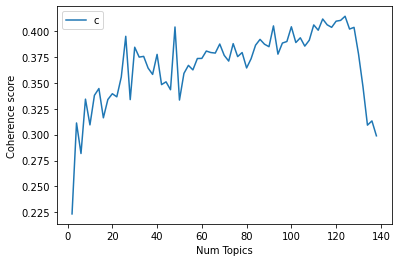

In [ ]:
# Show graph
limit=140; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# Select the model and print the topics
optimal_model = model_list[17]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=         x    y  topics  cluster      Freq
topic                                     
179    0.0  0.0       1        1  0.555556
66     0.0  0.0       2        1  0.555556
64     0.0  0.0       3        1  0.555556
63     0.0  0.0       4        1  0.555556
62     0.0  0.0       5        1  0.555556
...    ...  ...     ...      ...       ...
118    0.0  0.0     176        1  0.555556
117    0.0  0.0     177        1  0.555556
116    0.0  0.0     178        1  0.555556
115    0.0  0.0     179        1  0.555556
0      0.0  0.0     180        1  0.555556

[180 rows x 5 columns], topic_info=                                    Term      Freq  ...  logprob loglift
0                          Combinatorics  33.00000  ...  30.0000    30.0
11668                 Laurent polynomial  33.00000  ...  29.0000    29.0
11674                    Heyting algebra  33.00000  ...  28.0000    28.0
11673                 Closure (topology)  33.00000  ...  27.0000    27.0
11672                 Algebraic interior  33.00000  ...  26.0000    26.0
...                                  ...       ...  ...      ...     ...
5821                            Isotropy   0.18656  ...  -9.7703     0.0
5820                  Ping (video games)   0.18656  ...  -9.7703     0.0
5819                        Linux kernel   0.18656  ...  -9.7703     0.0
5818   Internet Control Message Protocol   0.18656  ...  -9.7703     0.0
5817                 Symbolic simulation   0.18656  ...  -9.7703     0.0

[5430 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[180, 67, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 66, 68, 179, 69, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 46, 45, 44, 43, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 21, 22, 23, 34, 42, 41, 40, 39, 38, 37, 36, 35, 33, 24, 32, 31, 30, 29, 28, 27, 26, 25, 89, 90, 91, 136, 156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 157, 158, 159, 170, 178, 177, 176, 175, 174, 173, 172, 171, 169, 160, 168, 167, 166, 165, 164, 163, 162, 161, 137, 135, 92, 134, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 112, 113, 114, 125, 133, 132, 131, 130, 129, 128, 127, 126, 124, 115, 123, 122, 121, 120, 119, 118, 117, 116, 1])

In [ ]:
# Loop over the field of studies and get the topic for each fos (author wise)

In [ ]:
fos_multi_list[0]

['Matrix (mathematics)',
 'Radar',
 'Inequality',
 'Combinatorics',
 'Discrete mathematics',
 'Mathematics']

In [ ]:
topic_set = set()
topic_list = list()

for i in range(len(fos_multi_list)):
  for j in range(len(fos_multi_list[i])):
    topic_probs = lda_model.get_term_topics(fos_multi_list[i][j])
    ctr = 0
    for (a, b) in topic_probs:
      ctr += 1
      if ctr > 25:
        break
      topic_set.add(str(a))    
  topic_list.append(tuple(topic_set))
  topic_set.clear()



In [ ]:
len(topic_list[500])

6

In [ ]:
topic_list[0]

('12', '27', '115', '118', '5', '25', '96', '77')

In [ ]:
sum = 0
for i in range(len(fos_multi_list)):
  sum += len(fos_multi_list[i])

print(sum / len(fos_multi_list))

9.214169278996865


In [ ]:
sum = 0
for i in range(len(topic_list)):
  sum += len(topic_list[i])

print(sum / len(topic_list))

20.293291536050155


### Generate the reduced ote feature mat (done after topic modelling for field of studies)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

In [ ]:
# for topic list tuple
s = topic_list
s = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=fos_dff.index)

In [ ]:
s

,0,1,10,100,101,102,103,104,105,106,107,108,109,11,110,111,112,113,114,115,116,117,118,119,12,13,14,15,16,17,18,19,2,20,21,22,23,24,25,26,...,63,64,65,66,67,68,69,7,70,71,72,73,74,75,76,77,78,79,8,80,81,82,83,84,85,86,87,88,89,9,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,1,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63795,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
63796,1,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
63797,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
63798,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [ ]:
# s = fos_dff['FOS_BEST']
# s = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=fos_dff.index)

In [ ]:
# Drop the columns with noise (decimal col names), only do if LDA is not applied
cols_to_remove = []
for col in list(s.columns):
  if col.replace('.','',1).isdigit():
    cols_to_remove.append(col)

print(len(list(s.columns)))
s.drop(columns=cols_to_remove, axis=1, inplace=True)
print(len(list(s.columns)))
# cols = list(s.columns)
# print(cols[4])
# print(type(cols[4]))
# print(cols[4].isdecimal())
# tmp = cols[4]
# print(tmp.replace('.','',1).isdigit())

In [ ]:
# print(list(s.columns))
s.columns

Index(['0', '1', '10', '100', '101', '102', '103', '104', '105', '106',
       ...
       '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'],
      dtype='object', length=120)

In [ ]:
# s['0.0'].drop_duplicates()

In [ ]:
# fos_dff.head()

In [ ]:
fos_dff['sortedkey'][45562].keys()

dict_keys(['0.0', "Witsenhausen's counterexample", 'Low-density parity-check code', 'Distortion', 'Decoding methods', 'Scaling', 'Network topology', 'Geometric networks', 'Channel capacity', 'Binary symmetric channel'])

In [ ]:
s.head()

,0,1,10,100,101,102,103,104,105,106,107,108,109,11,110,111,112,113,114,115,116,117,118,119,12,13,14,15,16,17,18,19,2,20,21,22,23,24,25,26,...,63,64,65,66,67,68,69,7,70,71,72,73,74,75,76,77,78,79,8,80,81,82,83,84,85,86,87,88,89,9,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,1,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0


In [ ]:
fos_dff.head()

,name,fos,title,key,id,sortedkey,FOS_BEST
0,A Aart Blokhuis,Discrete mathematics:0.4204095:Combinatorics:0...,Bounds for the size of radar arrays,"{'Matrix (mathematics)': ['0.4815577'], 'Radar...",40567,"{'Matrix (mathematics)': ['0.4815577'], 'Radar...","[Matrix (mathematics), Radar, Inequality, Comb..."
1,A Alejandro Montes Garcia,Empirical research:0.471031338:Cluster analysi...,Effects of Evolutionary Linguistics in Text Cl...,"{'Cluster analysis': ['0.547445059'], 'Evoluti...",49252,"{'Cluster analysis': ['0.547445059'], 'Evoluti...","[Cluster analysis, Evolutionary linguistics, E..."
2,A Anne Rozinat,Versa:0.441023469:Business process:0.4714488:T...,Conformance testing : Measuring the fit and ap...,"{'Transaction log': ['0.555015'], 'Conformance...",49712,"{'Transaction log': ['0.555015'], 'Conformance...","[Transaction log, Conformance testing, Referen..."
3,A Arakala,Biometrics:0.4345782:Minutiae:0.700131357:Fing...,Fuzzy extractors for minutiae-based fingerprin...,"{'Minutiae': ['0.700131357'], 'Fingerprint rec...",17784,"{'Minutiae': ['0.700131357'], 'Fingerprint rec...","[Minutiae, Fingerprint recognition, Authentica..."
4,A Campilho,Image segmentation:0.619028568:Discrete mathem...,Automatic image segmentation using a deformabl...,"{'Image segmentation': ['0.619028568'], 'Class...",12535,"{'Image segmentation': ['0.619028568'], 'Class...","[Image segmentation, Classical electromagnetis..."


In [ ]:
fos_dff.drop(columns=["fos", "title", "key", "sortedkey"], axis=1, inplace=True)
fos_dff_copy = fos_dff.copy()
fos_dff.drop(columns=["FOS_BEST", 'id'], axis=1, inplace=True)
fos_dff.head()

,name
0,A Aart Blokhuis
1,A Alejandro Montes Garcia
2,A Anne Rozinat
3,A Arakala
4,A Campilho


In [ ]:
fos_dff_copy.head()

,name,id,FOS_BEST
0,A Aart Blokhuis,40567,"[Matrix (mathematics), Radar, Inequality, Comb..."
1,A Alejandro Montes Garcia,49252,"[Cluster analysis, Evolutionary linguistics, E..."
2,A Anne Rozinat,49712,"[Transaction log, Conformance testing, Referen..."
3,A Arakala,17784,"[Minutiae, Fingerprint recognition, Authentica..."
4,A Campilho,12535,"[Image segmentation, Classical electromagnetis..."


In [ ]:
horizontal_feature = pd.concat([fos_dff, s], axis=1)

In [ ]:
horizontal_feature.head(10)

,name,0,1,10,100,101,102,103,104,105,106,107,108,109,11,110,111,112,113,114,115,116,117,118,119,12,13,14,15,16,17,18,19,2,20,21,22,23,24,25,...,63,64,65,66,67,68,69,7,70,71,72,73,74,75,76,77,78,79,8,80,81,82,83,84,85,86,87,88,89,9,90,91,92,93,94,95,96,97,98,99
0,A Aart Blokhuis,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,A Alejandro Montes Garcia,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0
2,A Anne Rozinat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,A Arakala,1,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,A Campilho,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0
5,A Hammers,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,A Jakoby,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0
7,A Kaptein,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
8,A Leonardis,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
9,A Min Tjoa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
horizontal_feature.shape

(63800, 121)

In [ ]:
del fos_dff
del s

In [ ]:
horizontal_feature['name'] = horizontal_feature['name'].apply(lambda x: dic_authors[x])

In [ ]:
horizontal_feature.head()

,name,0,1,10,100,101,102,103,104,105,106,107,108,109,11,110,111,112,113,114,115,116,117,118,119,12,13,14,15,16,17,18,19,2,20,21,22,23,24,25,...,63,64,65,66,67,68,69,7,70,71,72,73,74,75,76,77,78,79,8,80,81,82,83,84,85,86,87,88,89,9,90,91,92,93,94,95,96,97,98,99
0,40567,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,49252,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0
2,49712,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,17784,1,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,12535,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0


In [ ]:
# Add features from feat df
cited_colab_feat = pd.DataFrame()
cited_colab_feat['cited_colabs'] = feat['cited_colabs']
horizontal_feature['cited_colabs'] = feat['cited_colabs']
for i in tqdm(range(len(horizontal_feature))):
  cited_colab_feat['cited_colabs'][i] = feat['cited_colabs'][horizontal_feature['name'][i]]

horizontal_feature['cited_colabs'] = cited_colab_feat['cited_colabs']
len(horizontal_feature['cited_colabs'].drop_duplicates())

100%|██████████| 63800/63800 [00:04<00:00, 14282.22it/s]


489

In [ ]:
# Add features from feat df
dir_colab_feat = pd.DataFrame()
dir_colab_feat['dir_colabs'] = feat['dir_colabs']
horizontal_feature['dir_colabs'] = feat['dir_colabs']
for i in tqdm(range(len(horizontal_feature))):
  dir_colab_feat['dir_colabs'][i] = feat['dir_colabs'][horizontal_feature['name'][i]]

horizontal_feature['dir_colabs'] = dir_colab_feat['dir_colabs']
len(horizontal_feature['dir_colabs'].drop_duplicates())

100%|██████████| 63800/63800 [00:04<00:00, 14658.98it/s]


108

In [ ]:
horizontal_feature.set_index("name", inplace=True)

In [ ]:
horizontal_feature.head()

,0,1,10,100,101,102,103,104,105,106,107,108,109,11,110,111,112,113,114,115,116,117,118,119,12,13,14,15,16,17,18,19,2,20,21,22,23,24,25,26,...,65,66,67,68,69,7,70,71,72,73,74,75,76,77,78,79,8,80,81,82,83,84,85,86,87,88,89,9,90,91,92,93,94,95,96,97,98,99,cited_colabs,dir_colabs
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40567,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000497,0.004167
49252,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0.000000,0.012500
49712,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.000000,0.004167
17784,1,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.000000,0.008333
12535,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0.000000,0.016667


### Logic to consolidate weights and assign them to corresponding node pairs (as stated in the notebook's start)

In [ ]:
# Add cosine_sim_score for calculating weights bw edges (to feed into the stellargraph)

In [ ]:
dff.head()

,node1,node2,source,target,commonAuthors,prefAttachment,totalNeighbours
0,1825,1827,188,190,4.0,90.0,15.0
1,1854,114209,217,16951,2.0,50.0,13.0
2,1859,1860,222,223,1.0,4.0,3.0
3,1983,1984,346,347,3.0,16.0,5.0
4,2131,135455,494,21268,1.0,8.0,5.0


In [ ]:
# dff['auth1'] = dff['source'].apply(lambda x: dic_authors[x])
# dff['auth2'] = dff['target'].apply(lambda x: dic_authors[x])

In [ ]:
fos_dff_copy.head()

,name,id,FOS_BEST
0,A Aart Blokhuis,40567,"[Matrix (mathematics), Radar, Inequality, Comb..."
1,A Alejandro Montes Garcia,49252,"[Cluster analysis, Evolutionary linguistics, E..."
2,A Anne Rozinat,49712,"[Transaction log, Conformance testing, Referen..."
3,A Arakala,17784,"[Minutiae, Fingerprint recognition, Authentica..."
4,A Campilho,12535,"[Image segmentation, Classical electromagnetis..."


In [ ]:
import gensim
from gensim.utils import simple_preprocess

In [ ]:
dictionary = gensim.corpora.Dictionary(list(fos_dff_copy['FOS_BEST']))

In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in list(fos_dff_copy['FOS_BEST'])]

from gensim import models

tfidf = models.TfidfModel(bow_corpus)

# from gensim.matutils import softcossim
from gensim import corpora
from gensim import corpora, models, similarities

feature_cnt = len(dictionary.token2id)

index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features = feature_cnt)

# index.num_best = 10



In [ ]:
!pip install pandarallel

In [ ]:
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=16)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
def getsimscore(x):
    r1 = fos_dff_copy[fos_dff_copy['id']==x['source']].index[0]
    r2 = fos_dff_copy[fos_dff_copy['id']==x['target']].index[0]
    score = index[tfidf[bow_corpus[r1]]][r2]
    return score

In [ ]:
dff.head()

,node1,node2,source,target,commonAuthors,prefAttachment,totalNeighbours
0,1825,1827,188,190,4.0,90.0,15.0
1,1854,114209,217,16951,2.0,50.0,13.0
2,1859,1860,222,223,1.0,4.0,3.0
3,1983,1984,346,347,3.0,16.0,5.0
4,2131,135455,494,21268,1.0,8.0,5.0


In [ ]:
dff['sim_score_cos'] = dff.apply(lambda x: getsimscore(x),axis=1)
# dff['sim_score_cos'] = dff['commonAuthors']

In [ ]:
dff.head()

,node1,node2,source,target,commonAuthors,prefAttachment,totalNeighbours,sim_score_cos
0,1825,1827,188,190,4.0,90.0,15.0,0.770027
1,1854,114209,217,16951,2.0,50.0,13.0,0.000000
2,1859,1860,222,223,1.0,4.0,3.0,1.000000
3,1983,1984,346,347,3.0,16.0,5.0,1.000000
4,2131,135455,494,21268,1.0,8.0,5.0,0.592721


In [ ]:
# Create a weight col by combining the features

In [ ]:
# Normalise thee feaatures to feed into the moddel
cn_mean = dff['commonAuthors'].mean()
cn_max = dff['commonAuthors'].max()
cn_min = dff['commonAuthors'].min()

pf_mean = dff['prefAttachment'].mean()
pf_max = dff['prefAttachment'].max()
pf_min = dff['prefAttachment'].min()

tn_mean = dff['totalNeighbours'].mean()
tn_max = dff['totalNeighbours'].max()
tn_min = dff['totalNeighbours'].min()

sim_mean = dff['sim_score_cos'].mean()
sim_max = dff['sim_score_cos'].max()
sim_min = dff['sim_score_cos'].min()

In [ ]:
dff['commonAuthors'] = dff['commonAuthors'].apply(lambda x: ((x - cn_min) / (cn_max - cn_min)))
dff['prefAttachment'] = dff['prefAttachment'].apply(lambda x: ((x - pf_min) / (pf_max - pf_min)))
dff['totalNeighbours'] = dff['totalNeighbours'].apply(lambda x: ((x - tn_min) / (tn_max - tn_min)))
dff['sim_score_cos'] = dff['sim_score_cos'].apply(lambda x: ((x - sim_min) / (sim_max - sim_min)))

In [ ]:
dff.head()

,node1,node2,source,target,commonAuthors,prefAttachment,totalNeighbours,sim_score_cos
0,1825,1827,188,190,0.085106,0.009009,0.073034,0.770026
1,1854,114209,217,16951,0.042553,0.004960,0.061798,0.000000
2,1859,1860,222,223,0.021277,0.000304,0.005618,1.000000
3,1983,1984,346,347,0.063830,0.001518,0.016854,1.000000
4,2131,135455,494,21268,0.021277,0.000709,0.016854,0.592721


In [ ]:
dff['weight'] = dff['commonAuthors'] + dff['prefAttachment'] + dff['totalNeighbours'] + dff['sim_score_cos']
dff.head()

,node1,node2,source,target,commonAuthors,prefAttachment,totalNeighbours,sim_score_cos,weight
0,1825,1827,188,190,0.085106,0.009009,0.073034,0.770026,0.937176
1,1854,114209,217,16951,0.042553,0.004960,0.061798,0.000000,0.109311
2,1859,1860,222,223,0.021277,0.000304,0.005618,1.000000,1.027198
3,1983,1984,346,347,0.063830,0.001518,0.016854,1.000000,1.082202
4,2131,135455,494,21268,0.021277,0.000709,0.016854,0.592721,0.631560


In [ ]:
wt_mean = dff['weight'].mean()
wt_max = dff['weight'].max()
wt_min = dff['weight'].min()
dff['weight'] = dff['weight'].apply(lambda x: ((x - wt_min) / (wt_max - wt_min)))
dff.head()

,node1,node2,source,target,commonAuthors,prefAttachment,totalNeighbours,sim_score_cos,weight
0,1825,1827,188,190,0.085106,0.009009,0.073034,0.770026,0.373170
1,1854,114209,217,16951,0.042553,0.004960,0.061798,0.000000,0.043526
2,1859,1860,222,223,0.021277,0.000304,0.005618,1.000000,0.409016
3,1983,1984,346,347,0.063830,0.001518,0.016854,1.000000,0.430918
4,2131,135455,494,21268,0.021277,0.000709,0.016854,0.592721,0.251478


In [ ]:
dff.drop(columns=["node1", "node2", "commonAuthors", "prefAttachment", "totalNeighbours", "sim_score_cos"], axis=1, inplace=True)
dff.head()

,source,target,weight
0,188,190,0.373170
1,217,16951,0.043526
2,222,223,0.409016
3,346,347,0.430918
4,494,21268,0.251478


## GraphSAGE integration

In [ ]:
from stellargraph import StellarGraph

In [ ]:
# sg = StellarGraph(feat,edges=dff)
sg = StellarGraph(horizontal_feature,edges=dff)

In [ ]:
print(type(sg))
print(sg.info())

<class 'stellargraph.core.graph.StellarGraph'>
StellarGraph: Undirected multigraph
 Nodes: 63800, Edges: 120775

 Node types:
  default: [63800]
    Features: float32 vector, length 122
    Edge types: default-default->default

 Edge types:
    default-default->default: [120775]
        Weights: range=[0, 1], mean=0.269744, std=0.146664
        Features: none


In [ ]:
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification

In [ ]:
edge_splitter_test = EdgeSplitter(sg)

In [ ]:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 12077 positive and 12077 negative edges. **


In [ ]:
edge_splitter_val = EdgeSplitter(G_test)

In [ ]:
G_val, edge_ids_val, edge_labels_val = edge_splitter_val.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 10869 positive and 10869 negative edges. **


In [ ]:
edge_splitter_train = EdgeSplitter(G_val)

In [ ]:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 9782 positive and 9782 negative edges. **


In [ ]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 63800, Edges: 88047

 Node types:
  default: [63800]
    Features: float32 vector, length 122
    Edge types: default-default->default

 Edge types:
    default-default->default: [88047]
        Weights: range=[0, 1], mean=0.249018, std=0.145965
        Features: none


In [ ]:
print(G_val.info())

StellarGraph: Undirected multigraph
 Nodes: 63800, Edges: 97829

 Node types:
  default: [63800]
    Features: float32 vector, length 122
    Edge types: default-default->default

 Edge types:
    default-default->default: [97829]
        Weights: range=[0, 1], mean=0.256783, std=0.14671
        Features: none


In [ ]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 63800, Edges: 108698

 Node types:
  default: [63800]
    Features: float32 vector, length 122
    Edge types: default-default->default

 Edge types:
    default-default->default: [108698]
        Weights: range=[0, 1], mean=0.263494, std=0.146714
        Features: none


In [ ]:
batch_size = 20
epochs = 40

In [ ]:
num_samples = [20, 10]

In [ ]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples, weighted=True)

In [ ]:
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [ ]:
val_gen = GraphSAGELinkGenerator(G_val, batch_size, num_samples, weighted=True)
val_flow = val_gen.flow(edge_ids_val, edge_labels_val)

In [ ]:
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples, weighted=True)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [ ]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, aggregator=AttentionalAggregator, bias=True, dropout=0.3
)

In [ ]:
x_inp, x_out = graphsage.in_out_tensors()

In [ ]:
prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [ ]:
import tensorflow.keras as keras # DO NOT USE KERAS DIRECTLY
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

In [ ]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-4),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
init_train_metrics = model.evaluate(train_flow)
init_val_metrics = model.evaluate(val_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValidation Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1208/1208 [==============================] - 58s 48ms/step - loss: 0.7132 - acc: 0.5760

Train Set Metrics of the initial (untrained) model:
	loss: 0.7155
	acc: 0.5777

Validation Set Metrics of the initial (untrained) model:
	loss: 0.7209
	acc: 0.5775

Test Set Metrics of the initial (untrained) model:
	loss: 0.7132
	acc: 0.5760


In [ ]:
history = model.fit(train_flow, epochs=epochs, validation_data=val_flow, verbose=1)

Epoch 1/40
979/979 [==============================] - 93s 92ms/step - loss: 0.3998 - acc: 0.8247 - val_loss: 0.3222 - val_acc: 0.8605
Epoch 2/40
979/979 [==============================] - 90s 91ms/step - loss: 0.3496 - acc: 0.8646 - val_loss: 0.3110 - val_acc: 0.8628
Epoch 3/40
979/979 [==============================] - 90s 92ms/step - loss: 0.3353 - acc: 0.8717 - val_loss: 0.3085 - val_acc: 0.8729
Epoch 4/40
979/979 [==============================] - 89s 91ms/step - loss: 0.3298 - acc: 0.8766 - val_loss: 0.2985 - val_acc: 0.8735
Epoch 5/40
979/979 [==============================] - 89s 90ms/step - loss: 0.3189 - acc: 0.8769 - val_loss: 0.2975 - val_acc: 0.8713
Epoch 6/40
979/979 [==============================] - 89s 91ms/step - loss: 0.3142 - acc: 0.8798 - val_loss: 0.2867 - val_acc: 0.8806
Epoch 7/40
979/979 [==============================] - 90s 92ms/step - loss: 0.3083 - acc: 0.8814 - val_loss: 0.2939 - val_acc: 0.8821
Epoch 8/40
979/979 [==============================] - 89s 91ms

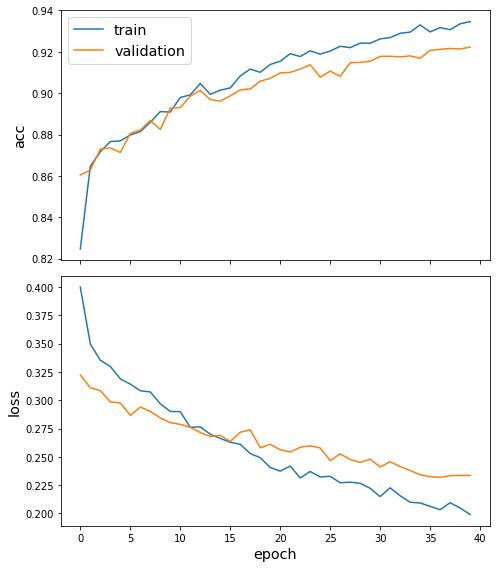

In [ ]:
import stellargraph
stellargraph.utils.plot_history(history)

In [ ]:
model.save(r'/content/gdrive/MyDrive/GraphSAGE_Ndarrays/weighted/keras')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/GraphSAGE_Ndarrays/weighted/keras/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/GraphSAGE_Ndarrays/weighted/keras/assets


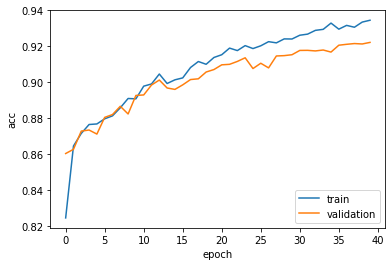

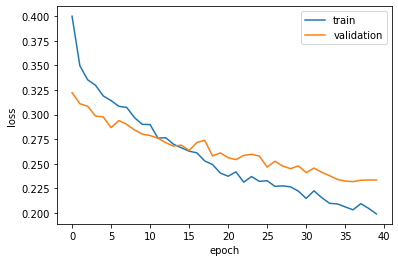

In [ ]:
# Plot acc and loss using matplotlib
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.savefig(r'/content/gdrive/MyDrive/GraphSAGE_Ndarrays/weighted/plots/accuracy.png', format='png', dpi=300)
plt.savefig(r'/content/gdrive/MyDrive/GraphSAGE_Ndarrays/weighted/plots/acc.eps', format='eps', dpi=300)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig(r'/content/gdrive/MyDrive/GraphSAGE_Ndarrays/weighted/plots/loss.png', format='png', dpi=300)
plt.savefig(r'/content/gdrive/MyDrive/GraphSAGE_Ndarrays/weighted/plots/los.eps', format='eps', dpi=300)
plt.show()

In [ ]:
train_metrics = model.evaluate(train_flow)
val_metrics = model.evaluate(val_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValidation Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1208/1208 [==============================] - 56s 47ms/step - loss: 0.2137 - acc: 0.9320

Train Set Metrics of the trained model:
	loss: 0.1776
	acc: 0.9405

Validation Set Metrics of the trained model:
	loss: 0.2291
	acc: 0.9240

Test Set Metrics of the trained model:
	loss: 0.2137
	acc: 0.9320


In [ ]:
print("test_matrics: ", test_metrics)

test_matrics:  [0.213718444108963, 0.9320195317268372]


### The code ahead is to generate a raw csv with probabilities of link predicted. This csv can be further  used to calculate different metrics like acc, precision, recall, AP, auc etc.

In [ ]:
y_true = test_flow.targets

In [ ]:
print(y_true)

[1 1 1 ... 0 0 0]


In [ ]:
y_pred = model.predict(test_flow, verbose=1)

1208/1208 [==============================] - 53s 43ms/step


In [ ]:
y_pred = y_pred[:, 0]

In [ ]:
y_pred

array([0.92905945, 0.98849446, 0.9994559 , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [ ]:
data = []
for i in range(len(y_true)):
    data.append([y_true[i], y_pred[i]])

In [ ]:
df = pd.DataFrame(data, columns=['y_true', 'y_pred'])

In [ ]:
df.head()

,y_true,y_pred
0,1,0.929059
1,1,0.988494
2,1,0.999456
3,1,0.995510
4,1,0.985822


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df.to_csv("raw_data.csv", index=False)

In [ ]:
!ls

gdrive	      sample_data		 spark-3.0.0-bin-hadoop3.2.tgz
raw_data.csv  spark-3.0.0-bin-hadoop3.2


In [ ]:
!cp raw_data.csv /content/gdrive/MyDrive/GraphSAGE_Ndarrays/weighted/csvSave